In [127]:
import os
import platform
import pandas as pd
import cv2 as cv
import json


from tqdm import tqdm
from glob import glob, iglob
from matplotlib import image, pyplot as plt, patches

In [3]:
gt_train = pd.read_csv('../assets/dataset/gt_train.csv')

In [120]:
with open('../assets/dataset/raw_train.txt') as json_file:
    data = json.load(json_file)
    

In [118]:
for idx in tqdm(range(len(data))):
  df = gt_train.loc[gt_train["00000000"] == int(data[idx]["filename"].replace(".jpg", ""))]
  objects = []
  for x in range(len(df)):
    obj = {
      "class" : df.iloc[x,1],
      "x" : df.iloc[x,2] / data[idx]["image-size"][1],
      "y" : df.iloc[x,3] / data[idx]["image-size"][0],
      "w" : (df.iloc[x,4] - df.iloc[x,2]) / data[idx]["image-size"][1],
      "h" : (df.iloc[x,5] - df.iloc[x,3]) / data[idx]["image-size"][0]
    }
    objects.append(obj) 
  data[idx]["objects"] = objects


100%|██████████| 110000/110000 [03:53<00:00, 471.61it/s]


In [6]:
def open_image(path, name, show = False):
    if platform.system() == 'Windows':
        idx = name.replace('/'," ").split(" ")
        name = os.path.join(idx[0], idx[1])
    
    path = os.path.join(path,name)
    img = image.imread(path)
    
    if show:
        plt.figure(figsize = (15,15))
        plt.imshow(img, interpolation='nearest')
        plt.show()
    
    return img

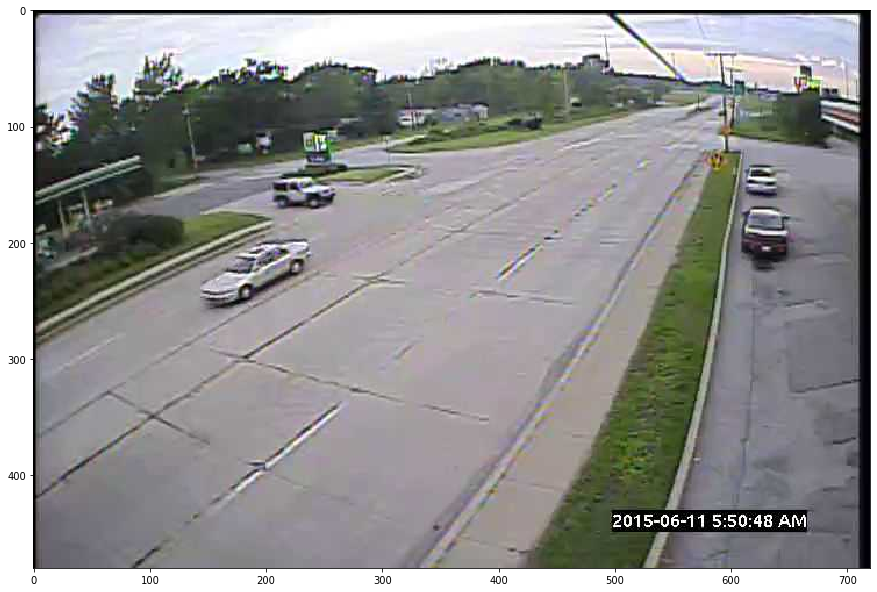

(480, 720, 3)


In [125]:
img = open_image('../assets/dataset/train', '00093515.jpg', True)
print(img.shape)

In [ ]:
def draw_image(image, notation):
  fig, ax = plt.subplots(figsize = (15,15))
  ax.imshow(image, interpolation='nearest')
  objs = notation["objects"]
  h = notation["image-size"][0]
  w = notation["image-size"][1]
  for obj in objs:
    rect = patches.Rectangle((int(obj["x"]* w), int(obj["y"] * h)), int(obj["w"] * w), int(obj["h"] * h), linewidth=1, edgecolor='r', facecolor='none') 
    ax.add_patch(rect)
  
  plt.show()
  

In [119]:
with open('../assets/dataset/raw_train.txt', 'w') as file:
    json.dump(data, file)